In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [65]:
PATH = '/Users/stevenneira/Desktop/FlowersIA/'
INPATH = PATH + 'inImages'
OUTPATH = PATH + 'outImages'
CHECKP = PATH + 'checkpoints'
IMG_WIDTH = 256
IMG_HEIGTH = 256

In [66]:
listUrls = os.listdir(INPATH)
imgUrls = np.copy(listUrls)
np.random.shuffle(imgUrls)
n = 500;
train_n = round(n * 0.80);

tr_images = imgUrls[:train_n]
ts_images = imgUrls[train_n:n]
print(len(ts_images),len(tr_images),len(imgUrls))

100 400 8189


In [67]:
#Reescalar images
def resize(in_img, out_img, heigth, widht):
    in_img = tf.image.resize(in_img, [heigth,widht])
    out_img = tf.image.resize(out_img, [heigth,widht])
    return in_img, out_img

#Normalize images [-1,1] range
def normalize(in_img, out_img, heigth, widht):
    in_img = (in_img/127.5) - 1
    out_img = (out_img/127.5) - 1
    return in_img, out_img

def random_jitter(in_img, out_img):
    in_img, out_img = resize(in_img,out_img, 286,286)
    stacked_image = tf.stack([in_img,out_img], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2,IMG_HEIGTH,IMG_WIDTH, 3])
    in_img, out_img = cropped_image[0],cropped_image[1]
    
    if tf.random.uniform(()) > 0.5:
        in_img = tf.image.flip_left_right(in_img)
        out_img = tf.image.flip_left_right(out_img)
        
    return in_img, out_img;
        
def load_image(filename, augment=True):
    in_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)
    out_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)
    in_img, out_img = resize(in_img,out_img, IMG_HEIGTH, IMG_WIDTH)
    if augment:
        in_img, out_img = random_jitter(in_img, out_img)
        
    in_img, out_img = normalize(in_img, out_img,IMG_HEIGTH,IMG_WIDTH)
    return in_img, out_img;

def load_train_image(filename):
    return load_image(filename, True)
def load_test_image(filename):
    return load_image(filename, False)

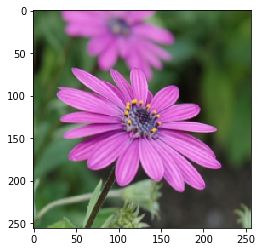

In [80]:


imgR = ((load_train_image(tr_images[0])[1])+1 )/2
plt.imshow(imgR) 